# Define configurations

In [1]:
user = 'participant2'
frequency = '15min' # 15min | 15s
dataset_type = '' # ''

if frequency == '15min':
    record_size_per_day = 96
elif frequency == '15s':
    record_size_per_day = 5760

# Columns to include    
if dataset_type == '':
    columns = [ 'timestamp', 'heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem', 'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency',
            'time_from_last_drug_taken', 'wearing_off' ]

metrics = {
    'balanced_accuracy': 'Bal. Acc.',
    'f1_score': 'F1 Score',
    'accuracy': 'Acc.',
    'precision': 'Precision',
    'sensitivity': 'Recall / Sn',
    'specificity': 'Sp',
    'auc': 'AUC'
}

# Preparation

## Load libraries

In [2]:
from datetime import datetime
from datetime import timedelta
from typing import Union, Generator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

import sklearn
from photonai.base import Hyperpipe, PipelineElement, Stack, Switch
from photonai.optimization import FloatRange, IntegerRange, Categorical, BooleanSwitch, PhotonHyperparam
from photonai.optimization import Categorical as PhotonCategorical
from photonai.optimization import MinimumPerformanceConstraint, DummyPerformanceConstraint, BestPerformanceConstraint
from photonai.optimization.base_optimizer import PhotonSlaveOptimizer
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

from skopt import Optimizer
from skopt.space import Real, Integer, Dimension
from skopt.space import Categorical as skoptCategorical
from photonai.photonlogger.logger import logger
from photonai.optimization.scikit_optimize.sk_opt import SkOptOptimizer

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=Warning)
from photonai.base import Hyperpipe
from photonai.optimization import MinimumPerformanceConstraint
from photonai.photonlogger import logger 

## Load combined data

In [3]:
combined_data = pd.read_excel(f'./data/combined_data/{dataset_type}combined_data_{user}_{frequency}.xlsx',
                              index_col="timestamp",
                              usecols=columns,
                              engine='openpyxl')
if dataset_type == '':
    # Define prediction horizon
    predict_ahead = pd.Timedelta(minutes=60)  # <- change to 2 or pd.Timedelta(seconds=15) as needed

    # Ensure datetime index
    combined_data = combined_data.sort_index()
    combined_data.index = pd.to_datetime(combined_data.index)

    # Estimate time delta between rows (assumes regular sampling)
    median_step = combined_data.index.to_series().diff().median()

    # How many steps to shift based on prediction horizon
    steps_ahead = int(predict_ahead / median_step)

    # Shift labels backward to align X at time t with y at t + n
    combined_data['wearing_off_future'] = combined_data['wearing_off'].shift(-steps_ahead)

    # Drop rows with NaNs from shifting
    combined_data = combined_data.dropna(subset=['wearing_off_future'])

    # Define X and y (keep X as DataFrame for .iloc to work)
    X = combined_data.loc[:, columns[1:-1]]  # or X = combined_data[feature_cols]
    y = combined_data['wearing_off_future'].astype(int).values


## Define Functions

In [4]:
# Show feature importances
def print_feature_importances(pipeline):
    output = ''
    if pipeline.optimum_pipe.feature_importances_ is None:
        output = 'Best Hyperparameter Configuration is a non-linear SVM, thus feature importances cannot be retrieved'
    else:
        output = 'Feature Importances using the Best Hyperparameter Config'
        if not [value.base_element.support_.tolist() for key, value in pipeline.optimum_pipe.elements if key == 'RFE']:
            if len(pipeline.optimum_pipe.feature_importances_) == 1:
                feature_importances = pipeline.optimum_pipe.feature_importances_[0]
            else:
                feature_importances = pipeline.optimum_pipe.feature_importances_
            output += '\n'
            output += tabulate(
                pd.DataFrame(
                    [np.around(feature_importances, decimals=4)],
                    columns=np.array(columns[1:-1])
                ).transpose().sort_values(by=[0], ascending=False, key=abs),
                tablefmt='psql', floatfmt=".4f", headers=['Features', 'Values']
            )
        else:
            mask = [value.base_element.support_.tolist() for key, value in pipeline.optimum_pipe.elements if key == 'RFE'][0]
            if len(pipeline.optimum_pipe.feature_importances_) == 1:
                feature_importances = pipeline.optimum_pipe.feature_importances_[0]
            else:
                feature_importances = pipeline.optimum_pipe.feature_importances_
            output += '\n'
            output += tabulate(
                pd.DataFrame(
                    [np.around(feature_importances, decimals=4)],
                    columns=np.array(columns[1:-1])[mask]
                ).transpose().sort_values(by=[0], ascending=False, key=abs),
                tablefmt='psql', floatfmt=".4f", headers=['Features', 'Values']
            )
    return output

In [5]:
def plot_cv_indices(cv, X, y, ax, n_splits=0, lw=20):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                    c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                    vmin=-.2, vmax=1.2)

    n_splits = ii + 1

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Paired)

    # Formatting
    yticklabels = list(range(n_splits)) + ['wearing-off']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Records\'s Index', ylabel="Folds",
           ylim=[n_splits+1.2, -.2], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


In [6]:
def plot_confusion_matrix_from_pipeline(pipeline):
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(
        pipeline.results_handler.get_test_predictions()['y_true'],
        pipeline.results_handler.get_test_predictions()['y_pred'],
        labels=[0,1], normalize=None)
    ax = plt.subplot()
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'25'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);

    # title_font = {'size':'21'}  # Adjust to fit
    # ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=25)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Good', 'Wearing-Off']);
    ax.yaxis.set_ticklabels(['Good', 'Wearing-Off']);
    plt.rc('text') # , usetex=False)
    plt.rc('font', family='serif')
    # plt.savefig('./participant2-downsampling-confusionmatrix-real.pdf', bbox_inches='tight')
    plt.show()

In [7]:
# Write other reports to summary file
def add_other_report_to_summary(pipeline, with_estimator_comparison=True):
    with open(f'{pipeline.output_settings.results_folder}/photon_summary.txt', "a+") as summary_file:
        # 1. Write comparison of learning algorithms
        if with_estimator_comparison:
            summary_file.write("\n\n")
            summary_file.write("Comparison on learning algorithms on validation set")
            summary_file.write("\n")
            summary_file.write(str(pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator()))

        # 2. Write feature importance
        summary_file.write("\n\n")
        summary_file.write("Feature Importance")
        summary_file.write(print_feature_importances(pipeline))
        
        # 3. Write beautified average test performance across outer folds
        # a. Get Average Test Performance Across Outer Folds
        test_metric_result = pipeline.results.get_test_metric_dict()
        
        # b. Replace display metric name
        #   Reference: https://stackoverflow.com/a/55250496/2303766
        test_metric_result = { metrics[metric]: test_metric_result[metric]
                                  for metric, metric_name in metrics.items() if metric in test_metric_result
                             }
        
        # c. Add beautified average test performance across outer folds to file 
        summary_file.write("\n\n")
        summary_file.write("Average Test Performance Across Outer Folds")
        summary_file.write("\n")
        summary_file.write(
            tabulate(
                pd.DataFrame(
                    test_metric_result
                ).round(4).transpose(),
                tablefmt='psql', floatfmt=".4f", headers='keys'
            )
        )
        
        # 4. Write outer fold results
        summary_file.write("\n\n")
        summary_file.write("Outer Fold Best Estimators' Performance")
        summary_file.write("\n")
        handler = pipeline.results_handler
        performance_table = handler.get_performance_table()
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            summary_file.write(
                tabulate(
                    performance_table.loc[:, ['fold', 'best_config', 'n_train', 'n_validation']].transpose(),
                    tablefmt='psql', headers='keys'
                )
            )
            summary_file.write("\n")
            summary_file.write(
                tabulate(
                    performance_table.loc[:, ['fold'] + list(metrics.keys())].round(4).transpose(),
                    tablefmt='psql', floatfmt=".4f", headers='keys'
                )
            )
            
        outer_fold_performance = {}
        config_evals = handler.get_config_evaluations()
        for metric in metrics.keys():
            # print(f'{metric}')
            for i, j in enumerate(config_evals[metric]):
                if f'{metric}_mean' in outer_fold_performance:
                    # outer_fold_performance[f'{metric}_max'].append(np.max(j))
                    outer_fold_performance[f'{metric}_mean'].append(np.mean(j))
                    outer_fold_performance[f'{metric}_std'].append(np.std(j))
                else:
                    # outer_fold_performance[f'{metric}_max'] = [np.max(j)]
                    outer_fold_performance[f'{metric}_mean'] = [np.mean(j)]
                    outer_fold_performance[f'{metric}_std'] = [np.std(j)]
        summary_file.write("\n")
        summary_file.write(
            tabulate(
                pd.DataFrame(outer_fold_performance).round(4).transpose(),
                tablefmt='psql', floatfmt=".4f", headers='keys'
            )
        )

In [8]:
# PhotonAI Optimize Monkey-patch
#     Added random_state for Optimize for result replicability
def prepare(self, pipeline_elements: list, maximize_metric: bool) -> None:
    """
    Initializes hyperparameter search with scikit-optimize.

    Assembles all hyperparameters of the list of PipelineElements
    in order to prepare the hyperparameter space.
    Hyperparameters can be accessed via pipe_element.hyperparameters.

    Parameters:
        pipeline_elements:
            List of all PipelineElements to create the hyperparameter space.

        maximize_metric:
            Boolean to distinguish between score and error.

    """
    self.start_time = None
    self.optimizer = None
    self.hyperparameter_list = []
    self.maximize_metric = maximize_metric

    # build skopt space
    space = []
    for pipe_element in pipeline_elements:
        if pipe_element.__class__.__name__ == 'Switch':
            error_msg = 'Scikit-Optimize cannot operate in the specified hyperparameter space with a Switch ' \
                        'element. We recommend the use of SMAC.'
            logger.error(error_msg)
            raise ValueError(error_msg)

        if hasattr(pipe_element, 'hyperparameters'):
            for name, value in pipe_element.hyperparameters.items():
                # if we only have one value we do not need to optimize
                if isinstance(value, list) and len(value) < 2:
                    self.constant_dictionary[name] = value[0]
                    continue
                if isinstance(value, PhotonCategorical) and len(value.values) < 2:
                    self.constant_dictionary[name] = value.values[0]
                    continue
                skopt_param = self._convert_photonai_to_skopt_space(value, name)
                if skopt_param is not None:
                    space.append(skopt_param)

    if self.constant_dictionary:
        msg = "PHOTONAI has detected some one-valued params in your hyperparameters. Pleas use the kwargs for " \
              "constant values. This run ignores following settings: " + str(self.constant_dictionary.keys())
        logger.warning(msg)
        warnings.warn(msg)

    if len(space) == 0:
        msg = "Did not find any hyperparameter to convert into skopt space."
        logger.warning(msg)
        warnings.warn(msg)
    else:
        self.optimizer = Optimizer(space,
                                   base_estimator=self.base_estimator,
                                   n_initial_points=self.n_initial_points,
                                   initial_point_generator=self.initial_point_generator,
                                   acq_func=self.acq_func,
                                   acq_func_kwargs=self.acq_func_kwargs,
                                   random_state=4
                                  )
    self.ask = self.ask_generator()
    
#    Monkey patched new prepare function
SkOptOptimizer.prepare = prepare

## Visualize Data Split

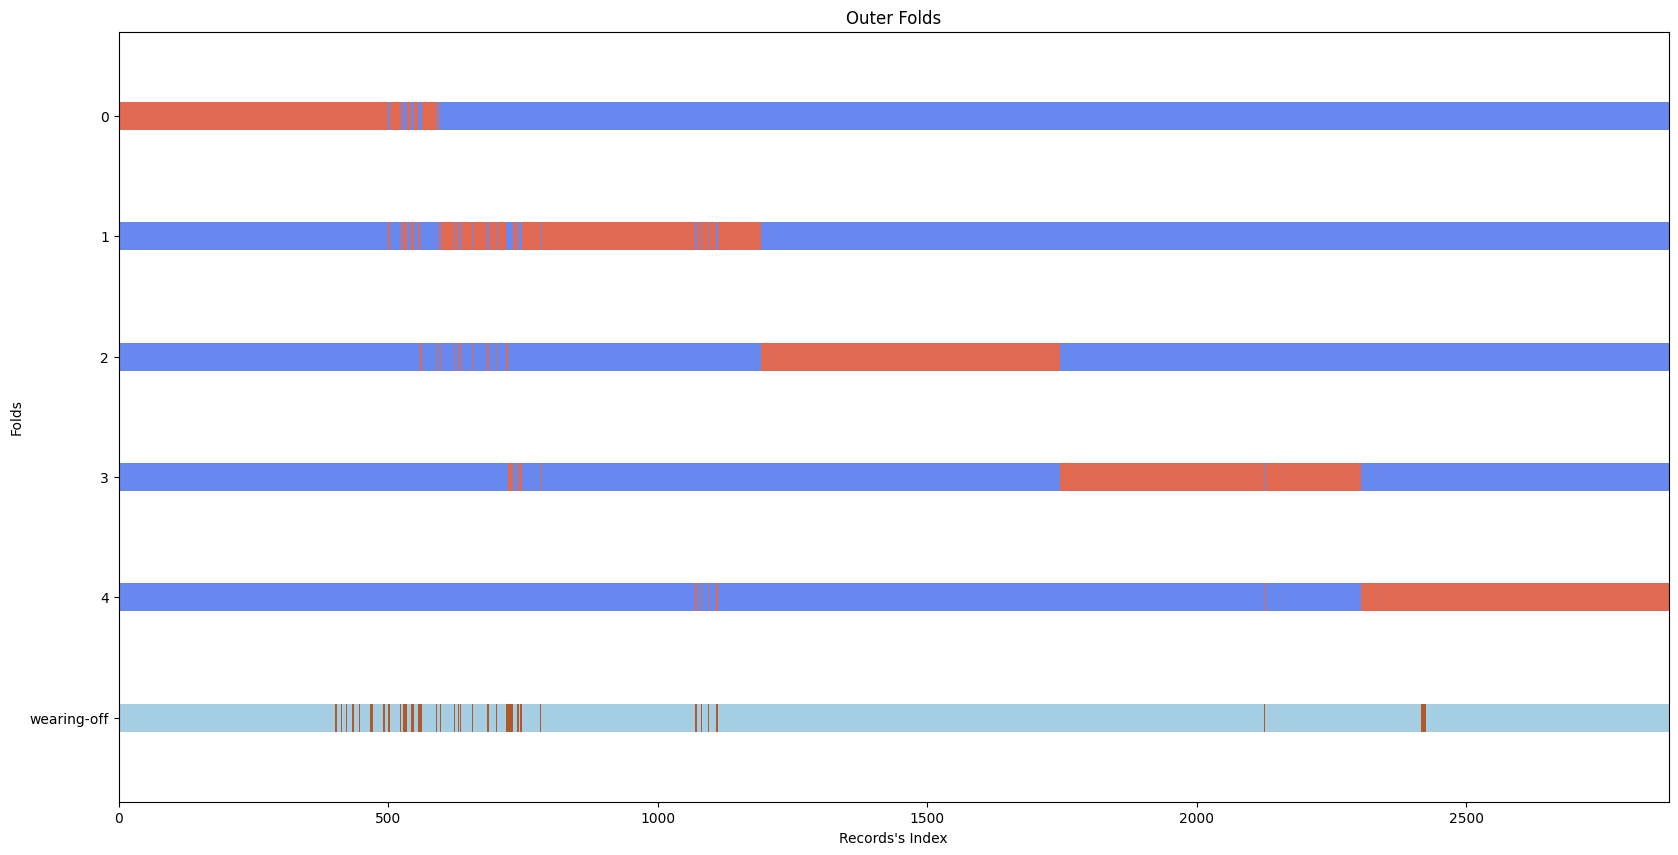

Train Set for Outer Fold 0
[ 508  509  510 ... 2873 2874 2875]

Train Set for Outer Fold 1
[   0    1    2 ... 2873 2874 2875]

Train Set for Outer Fold 2
[   0    1    2 ... 2873 2874 2875]

Train Set for Outer Fold 3
[   0    1    2 ... 2873 2874 2875]

Train Set for Outer Fold 4
[   0    1    2 ... 2310 2311 2312]



In [9]:
# Outer CV
fig, ax = plt.subplots(figsize=(20,10))
cv = StratifiedKFold(n_splits=5, shuffle=False)
plot_cv_indices(cv, X, y, ax)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
plt.title('Outer Folds')
# Save as file
# plt.savefig('./blockingtimeseriessplit.pdf', bbox_inches='tight')
plt.show()

training_folds = []
for train, test in cv.split(X, y):
    print(f'Train Set for Outer Fold {len(training_folds)}')
    print(train)
    training_folds.append(train)
    # print("Test")
    # print(test[0], test[-1])
    print()

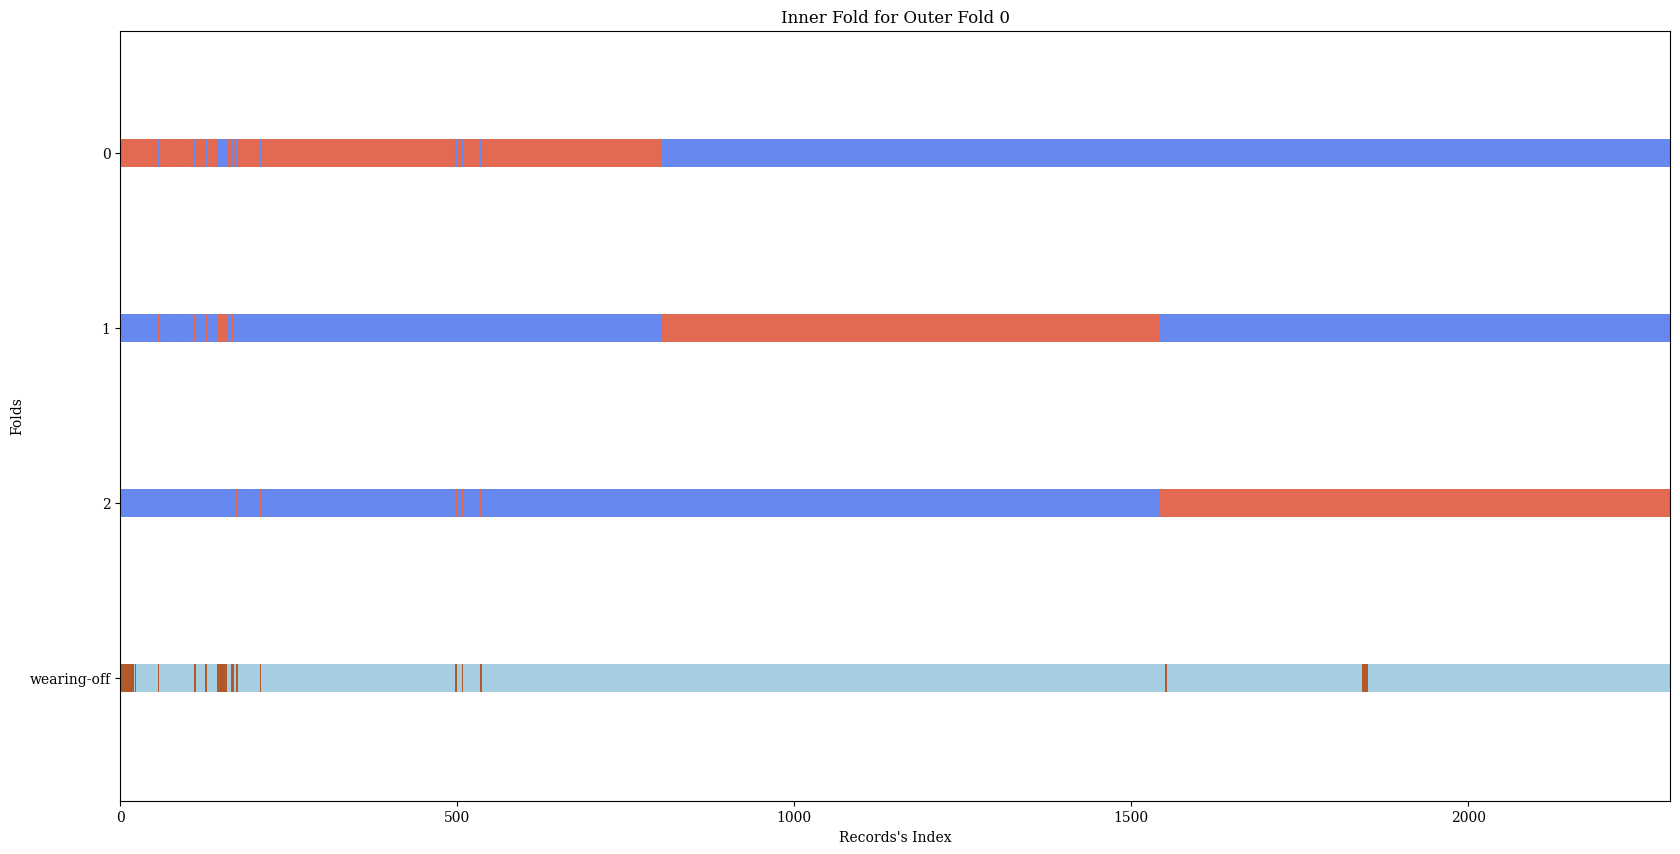

Train Sets for Outer Fold 0
Train Set for Inner Fold 0
[  54   62   66 ... 2297 2298 2299]

Train Set for Inner Fold 1
[   0    1    2 ... 2297 2298 2299]

Train Set for Inner Fold 2
[   0    1    2 ... 1546 1547 1548]



In [10]:
# Inner CV
outer_fold_number = 0

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
fig, ax = plt.subplots(figsize=(20,10))
cv = StratifiedKFold(n_splits=3, shuffle=False)
plot_cv_indices(cv, X.iloc[training_folds[outer_fold_number]], y[training_folds[outer_fold_number]], ax)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
plt.title(f'Inner Fold for Outer Fold {outer_fold_number}')
# Save as file
# plt.savefig('./blockingtimeseriessplit.pdf', bbox_inches='tight')
plt.show()

inner_training_folds = []
print(f'Train Sets for Outer Fold {outer_fold_number}')
for train, test in cv.split(X.iloc[training_folds[outer_fold_number]], y[training_folds[outer_fold_number]]):
    print(f'Train Set for Inner Fold {len(inner_training_folds)}')
    print(train)
    inner_training_folds.append(train)
    # print("Test")
    # print(test[0], test[-1])
    print()

# Pipeline

## Define learning algorithms

In [11]:
estimator_selection = Switch('estimators')
estimator_selection += PipelineElement("LogisticRegression",
                           hyperparameters={
                               'C': FloatRange(1, 10)
                           }, class_weight='balanced', random_state=4)
estimator_selection += PipelineElement("DecisionTreeClassifier",
                           hyperparameters={
                               'min_samples_split': IntegerRange(2,30),
                               'min_samples_leaf': IntegerRange(2,30)
                           }, random_state=4, criterion='gini')
estimator_selection += PipelineElement('LinearSVC',
                            hyperparameters={
                                'C': FloatRange(1, 25)
                            }, class_weight='balanced', random_state=4)
estimator_selection += PipelineElement('RandomForestClassifier', 
                            hyperparameters={
                                'min_samples_split': IntegerRange(2,30),
                                'max_features': ['auto', 'sqrt', 'log2']
                            }, random_state=4, criterion='gini', bootstrap=True)
estimator_selection += PipelineElement('GradientBoostingClassifier', 
                            hyperparameters={
                                'loss': ['deviance', 'exponential'],
                                'learning_rate': FloatRange(0.001, 1, 'logspace')
                            }, random_state=4)

## Initial Pipeline

In [12]:
initial_pipeline = Hyperpipe('1 - Initial Pipeline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

# Add learning algorithms to compare
initial_pipeline += estimator_selection

# Fit hyperpipe
initial_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(initial_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(initial_pipeline)

# # View CV splits for debugging
# for k,v in initial_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(initial_pipeline)

13/06/2025-15:10:39 | Output Folder: ./analysis/participant2_15min\1InitialPipeline_results_2025-06-13_15-10-39
PHOTONAI ANALYSIS: 1InitialPipeline
13/06/2025-15:10:39 | Preparing data and PHOTONAI objects for analysis...
13/06/2025-15:10:39 | Checking input data...
13/06/2025-15:10:39 | Running analysis with 2876 samples.
Found 2 target classes: [0 1]
Target classes are imbalanced: 96.55771905424201% belongs to 0
13/06/2025-15:10:39 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
13/06/2025-15:10:39 | Preparing data for outer fold 1...
13/06/2025-15:10:39 | Preparing Hyperparameter Optimization...
13/06/2025-15:10:39 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:10:57 | Computed configuration 96/150 in 0:00:00.185536
13/06/2025-15:10:57 | Performance:             balanced_accuracy - Train: 0.9327, Validation: 0.3846
13/06/2025-15:10:57 | Best Performance So Far: balanced_accuracy - Train: 0.7973, Validation: 0.6419
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:10:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:10:57 | Computed configuration 97/150 in 0:00:00.181886
13/06/2025-15:10:57 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.3643
13/06/2025-15:10:57 | Best Performance So Far: balanced_accuracy - Train: 0.7973, Validation: 0.6419
------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:10:59 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:10:59 | Computed configuration 102/150 in 0:00:00.180548
13/06/2025-15:10:59 | Performance:             balanced_accuracy - Train: 0.9423, Validation: 0.3833
13/06/2025-15:10:59 | Best Performance So Far: balanced_accuracy - Train: 0.7973, Validation: 0.6419
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:10:59 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:02 | Computed configuration 109/150 in 0:00:00.180485
13/06/2025-15:11:02 | Performance:             balanced_accuracy - Train: 0.9327, Validation: 0.3860
13/06/2025-15:11:02 | Best Performance So Far: balanced_accuracy - Train: 0.7973, Validation: 0.6419
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:02 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:03 | Computed configuration 113/150 in 0:00:00.261274
13/06/2025-15:11:03 | Performance:             balanced_accuracy - Train: 0.9423, Validation: 0.3846
13/06/2025-15:11:03 | Best Performance So Far: balanced_accuracy - Train: 0.7973, Validation: 0.6419
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=16",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:04 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:05 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:05 | Computed configuration 117/150 in 0:00:00.187186
13/06/2025-15:11:05 | Performance:             balanced_accuracy - Train: 0.9615, Validation: 0.3643
13/06/2025-15:11:05 | Best Performance So Far: balanced_accuracy - Train: 0.7973, Validation: 0.6419
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter o

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:06 | Computed configuration 119/150 in 0:00:00.178552
13/06/2025-15:11:06 | Performance:             balanced_accuracy - Train: 0.9904, Validation: 0.3670
13/06/2025-15:11:06 | Best Performance So Far: balanced_accuracy - Train: 0.7973, Validation: 0.6419
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:06 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:11:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:08 | Computed configuration 125/150 in 0:00:00.263295
13/06/2025-15:11:08 | Performance:             balanced_accuracy - Train: 0.9423, Validation: 0.4554
13/06/2025-15:11:08 | Best Performance So Far: balanced_accuracy - Train: 0.7973, Validation: 0.6419
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:11:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:08 | Computed configuration 129/150 in 0:00:00.278300
13/06/2025-15:11:08 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:11:08 | Best Performance So Far: balanced_accuracy - Train: 0.7973, Validation: 0.6419
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:11:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:08 | Computed configuration 130/150 in 0:00:00.263309
13/06/2025-15:11:08 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.7281
13/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:11:38 | Computed configuration 96/150 in 0:00:00.179519
13/06/2025-15:11:38 | Performance:             balanced_accuracy - Train: 0.9259, Validation: 0.4383
13/06/2025-15:11:38 | Best Performance So Far: balanced_accuracy - Train: 0.8096, Validation: 0.5756
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:38 | Computed configuration 97/150 in 0:00:00.181512
13/06/2025-15:11:38 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.4275
13/06/2025-15:11:38 | Best Performance So Far: balanced_accuracy - Train: 0.8096, Validation: 0.5756
------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:39 | Computed configuration 102/150 in 0:00:00.179522
13/06/2025-15:11:39 | Performance:             balanced_accuracy - Train: 0.9537, Validation: 0.4281
13/06/2025-15:11:39 | Best Performance So Far: balanced_accuracy - Train: 0.8096, Validation: 0.5756
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:40 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:42 | Computed configuration 108/150 in 0:00:00.188468
13/06/2025-15:11:42 | Performance:             balanced_accuracy - Train: 0.9167, Validation: 0.4281
13/06/2025-15:11:42 | Best Performance So Far: balanced_accuracy - Train: 0.8096, Validation: 0.5756
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=13",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:43 | Computed configuration 110/150 in 0:00:00.176519
13/06/2025-15:11:43 | Performance:             balanced_accuracy - Train: 0.9537, Validation: 0.4275
13/06/2025-15:11:43 | Best Performance So Far: balanced_accuracy - Train: 0.8096, Validation: 0.5756
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:43 | Computed configuration 112/150 in 0:00:00.180520
13/06/2025-15:11:43 | Performance:             balanced_accuracy - Train: 0.9630, Validation: 0.4275
13/06/2025-15:11:43 | Best Performance So Far: balanced_accuracy - Train: 0.8096, Validation: 0.5756
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=29",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:44 | Computed configuration 114/150 in 0:00:00.176528
13/06/2025-15:11:44 | Performance:             balanced_accuracy - Train: 0.9167, Validation: 0.4281
13/06/2025-15:11:44 | Best Performance So Far: balanced_accuracy - Train: 0.8096, Validation: 0.5756
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:45 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=29",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:11:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:47 | Computed configuration 120/150 in 0:00:00.189493
13/06/2025-15:11:47 | Performance:             balanced_accuracy - Train: 0.9352, Validation: 0.4281
13/06/2025-15:11:47 | Best Performance So Far: balanced_accuracy - Train: 0.8096, Validation: 0.5756
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0032967498356970054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:11:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:48 | Computed configuration 125/150 in 0:00:00.263295
13/06/2025-15:11:48 | Performance:             balanced_accuracy - Train: 0.9722, Validation: 0.4005
13/06/2025-15:11:48 | Best Performance So Far: balanced_accuracy - Train: 0.8096, Validation: 0.5756
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:11:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:48 | Computed configuration 129/150 in 0:00:00.260344
13/06/2025-15:11:48 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:11:48 | Best Performance So Far: balanced_accuracy - Train: 0.8096, Validation: 0.5756
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:11:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:11:49 | Computed configuration 130/150 in 0:00:00.277259
13/06/2025-15:11:49 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.3947
13/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:12:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:12:18 | Computed configuration 96/150 in 0:00:00.197503
13/06/2025-15:12:18 | Performance:             balanced_accuracy - Train: 0.8208, Validation: 0.5351
13/06/2025-15:12:18 | Best Performance So Far: balanced_accuracy - Train: 0.7329, Validation: 0.6684
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:12:18 | Computed configuration 97/150 in 0:00:00.189524
13/06/2025-15:12:18 | Performance:             balanced_accuracy - Train: 0.9528, Validation: 0.5675
13/06/2025-15:12:18 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:12:20 | Computed configuration 102/150 in 0:00:00.187053
13/06/2025-15:12:20 | Performance:             balanced_accuracy - Train: 0.9340, Validation: 0.5887
13/06/2025-15:12:20 | Best Performance So Far: balanced_accuracy - Train: 0.7329, Validation: 0.6684
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=2",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:20 | Skipped f

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:12:21 | Computed configuration 105/150 in 0:00:00.200030
13/06/2025-15:12:21 | Performance:             balanced_accuracy - Train: 0.9340, Validation: 0.5887
13/06/2025-15:12:21 | Best Performance So Far: balanced_accuracy - Train: 0.7329, Validation: 0.6684
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:21 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:12:22 | Computed configuration 108/150 in 0:00:00.183511
13/06/2025-15:12:22 | Performance:             balanced_accuracy - Train: 0.8491, Validation: 0.5331
13/06/2025-15:12:22 | Best Performance So Far: balanced_accuracy - Train: 0.7329, Validation: 0.6684
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:23 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=2",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:12:24 | Computed configuration 112/150 in 0:00:00.188498
13/06/2025-15:12:24 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5324
13/06/2025-15:12:24 | Best Performance So Far: balanced_accuracy - Train: 0.7329, Validation: 0.6684
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:24 | Skipped f

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:12:25 | Computed configuration 115/150 in 0:00:00.256314
13/06/2025-15:12:25 | Performance:             balanced_accuracy - Train: 0.8208, Validation: 0.5277
13/06/2025-15:12:25 | Best Performance So Far: balanced_accuracy - Train: 0.7329, Validation: 0.6684
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:26 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:12:27 | Computed configuration 119/150 in 0:00:00.199238
13/06/2025-15:12:27 | Performance:             balanced_accuracy - Train: 0.8585, Validation: 0.5317
13/06/2025-15:12:27 | Best Performance So Far: balanced_accuracy - Train: 0.7329, Validation: 0.6684
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=8",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:12:27 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:12:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:12:29 | Computed configuration 125/150 in 0:00:00.271304
13/06/2025-15:12:29 | Performance:             balanced_accuracy - Train: 0.8585, Validation: 0.4484
13/06/2025-15:12:29 | Best Performance So Far: balanced_accuracy - Train: 0.7329, Validation: 0.6684
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:12:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:12:29 | Computed configuration 129/150 in 0:00:00.257338
13/06/2025-15:12:29 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:12:29 | Best Performance So Far: balanced_accuracy - Train: 0.7329, Validation: 0.6684
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:12:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:12:29 | Computed configuration 130/150 in 0:00:00.261446
13/06/2025-15:12:29 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.4302
13/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:13:00 | Computed configuration 96/150 in 0:00:00.189493
13/06/2025-15:13:00 | Performance:             balanced_accuracy - Train: 0.8491, Validation: 0.3924
13/06/2025-15:13:00 | Best Performance So Far: balanced_accuracy - Train: 0.7266, Validation: 0.6377
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:00 | Computed configuration 97/150 in 0:00:00.190491
13/06/2025-15:13:00 | Performance:             balanced_accuracy - Train: 0.9434, Validation: 0.3947
13/06/2025-15:13:00 | Best Performance So Far: balanced_accuracy - Train: 0.7266, Validation: 0.6377
------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:01 | Computed configuration 102/150 in 0:00:00.188497
13/06/2025-15:13:01 | Performance:             balanced_accuracy - Train: 0.8679, Validation: 0.4730
13/06/2025-15:13:01 | Best Performance So Far: balanced_accuracy - Train: 0.7266, Validation: 0.6377
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:01 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=5",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:05 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:05 | Computed configuration 112/150 in 0:00:00.186501
13/06/2025-15:13:05 | Performance:             balanced_accuracy - Train: 0.8585, Validation: 0.4281
13/06/2025-15:13:05 | Best Performance So Far: balanced_accuracy - Train: 0.7266, Validation: 0.6377
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:06 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:07 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:07 | Computed configuration 116/150 in 0:00:00.193394
13/06/2025-15:13:07 | Performance:             balanced_accuracy - Train: 0.8868, Validation: 0.4143
13/06/2025-15:13:07 | Best Performance So Far: balanced_accuracy - Train: 0.7266, Validation: 0.6377
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:08 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:13:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:11 | Computed configuration 125/150 in 0:00:00.260340
13/06/2025-15:13:11 | Performance:             balanced_accuracy - Train: 0.8679, Validation: 0.5374
13/06/2025-15:13:11 | Best Performance So Far: balanced_accuracy - Train: 0.7266, Validation: 0.6377
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:13:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:11 | Computed configuration 129/150 in 0:00:00.259335
13/06/2025-15:13:11 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:13:11 | Best Performance So Far: balanced_accuracy - Train: 0.7266, Validation: 0.6377
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:13:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:11 | Computed configuration 130/150 in 0:00:00.259334
13/06/2025-15:13:11 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5816
13/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:13:41 | Computed configuration 96/150 in 0:00:00.172566
13/06/2025-15:13:41 | Performance:             balanced_accuracy - Train: 0.9717, Validation: 0.5361
13/06/2025-15:13:41 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.7233
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:41 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:41 | Computed configuration 97/150 in 0:00:00.172568
13/06/2025-15:13:41 | Performance:             balanced_accuracy - Train: 0.9811, Validation: 0.5354
13/06/2025-15:13:41 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.7233
------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=16",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:43 | Computed configuration 102/150 in 0:00:00.170515
13/06/2025-15:13:43 | Performance:             balanced_accuracy - Train: 0.9717, Validation: 0.5361
13/06/2025-15:13:43 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.7233
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=13",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:43 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:46 | Computed configuration 110/150 in 0:00:00.171573
13/06/2025-15:13:46 | Performance:             balanced_accuracy - Train: 0.9717, Validation: 0.5354
13/06/2025-15:13:46 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.7233
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:47 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=4",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:51 | Computed configuration 119/150 in 0:00:00.171513
13/06/2025-15:13:51 | Performance:             balanced_accuracy - Train: 0.9906, Validation: 0.5348
13/06/2025-15:13:51 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.7233
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:13:51 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:13:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:52 | Computed configuration 125/150 in 0:00:00.238314
13/06/2025-15:13:52 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6805
13/06/2025-15:13:52 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.7233
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:13:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:53 | Computed configuration 129/150 in 0:00:00.243348
13/06/2025-15:13:53 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:13:53 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.7233
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:13:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:13:53 | Computed configuration 130/150 in 0:00:00.257602
13/06/2025-15:13:53 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6744
13/

## Feature Selection Pipeline

In [13]:
classifier = LogisticRegression(random_state=4).fit(X, y)

feature_selection_pipeline = Hyperpipe('2 - Feature Selection Pipline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

feature_selection_pipeline += PipelineElement('RFE', 
                           hyperparameters={
                               'n_features_to_select': IntegerRange(2, (len(columns) - 2))
                           }, estimator=classifier)

feature_selection_pipeline += estimator_selection

# Fit hyperpipe
feature_selection_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(feature_selection_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(feature_selection_pipeline)

# # View CV splits for debugging
# for k,v in feature_selection_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(feature_selection_pipeline)

13/06/2025-15:14:07 | Output Folder: ./analysis/participant2_15min\2FeatureSelectionPipline_results_2025-06-13_15-14-07
PHOTONAI ANALYSIS: 2FeatureSelectionPipline
13/06/2025-15:14:07 | Preparing data and PHOTONAI objects for analysis...
13/06/2025-15:14:07 | Checking input data...
13/06/2025-15:14:07 | Running analysis with 2876 samples.
Found 2 target classes: [0 1]
Target classes are imbalanced: 96.55771905424201% belongs to 0
JsonTransformer was unable to create the .json file.
13/06/2025-15:14:07 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
13/06/2025-15:14:07 | Preparing data for outer fold 1...
13/06/2025-15:14:07 | Preparing Hyperparameter Optimization...
13/06/2025-15:14:07 | Running Dummy Estimator...
---------------------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:14:28 | Computed configuration 96/150 in 0:00:00.179519
13/06/2025-15:14:28 | Performance:             balanced_accuracy - Train: 0.9327, Validation: 0.3860
13/06/2025-15:14:28 | Best Performance So Far: balanced_accuracy - Train: 0.7692, Validation: 0.7039
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:14:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:14:28 | Computed configuration 97/150 in 0:00:00.169546
13/06/2025-15:14:28 | Performance:             balanced_accuracy - Train: 0.7885, Validation: 0.2595
13/06/2025-15:14:28 | Best Performance So Far: balanced_accuracy - Train: 0.7692, Validation: 0

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:14:28 | Computed configuration 100/150 in 0:00:00.179521
13/06/2025-15:14:28 | Performance:             balanced_accuracy - Train: 0.9327, Validation: 0.3846
13/06/2025-15:14:28 | Best Performance So Far: balanced_accuracy - Train: 0.7692, Validation: 0.7039
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:14:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:14:29 | Computed configuration 101/150 in 0:00:00.145609
13/06/2025-15:14:29 | Performance:             balanced_accuracy - Train: 0.7692, Validation: 0.2595
13/06/2025-15:14:29 | Best Performance So Far: balanced_accuracy - Train: 0.7692, Validation:

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:14:38 | Computed configuration 122/150 in 0:00:00.183543
13/06/2025-15:14:38 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:14:38 | Best Performance So Far: balanced_accuracy - Train: 0.7692, Validation: 0.7039
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_sco

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:14:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:14:39 | Computed configuration 127/150 in 0:00:00.140621
13/06/2025-15:14:39 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:14:39 | Best Performance So Far: balanced_accuracy - Train: 0.7692, Validation: 0.7039
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:14:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:14:39 | Computed configuration 128/150 in 0:00:00.113694
13/06/2025-15:14:39 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:14:40 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:14:40 | Computed configuration 131/150 in 0:00:00.459435
13/06/2025-15:14:40 | Performance:             balanced_accuracy - Train: 0.7478, Validation: 0.6020
13/06/2025-15:14:40 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.7281
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:15:11 | Computed configuration 96/150 in 0:00:00.184506
13/06/2025-15:15:11 | Performance:             balanced_accuracy - Train: 0.9537, Validation: 0.4281
13/06/2025-15:15:11 | Best Performance So Far: balanced_accuracy - Train: 0.7593, Validation: 0.5749
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:15:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:15:11 | Computed configuration 97/150 in 0:00:00.166555
13/06/2025-15:15:11 | Performance:             balanced_accuracy - Train: 0.7593, Validation: 0.4676
13/06/2025-15:15:11 | Best Performance So Far: balanced_accuracy - Train: 0.7593, Validation: 0

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:15:11 | Computed configuration 100/150 in 0:00:00.180515
13/06/2025-15:15:11 | Performance:             balanced_accuracy - Train: 0.9259, Validation: 0.4383
13/06/2025-15:15:11 | Best Performance So Far: balanced_accuracy - Train: 0.7593, Validation: 0.5749
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:15:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:15:12 | Computed configuration 101/150 in 0:00:00.145612
13/06/2025-15:15:12 | Performance:             balanced_accuracy - Train: 0.7593, Validation: 0.4676
13/06/2025-15:15:12 | Best Performance So Far: balanced_accuracy - Train: 0.7593, Validation:

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=5",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:15:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:15:20 | Computed configuration 119/150 in 0:00:00.176499
13/06/2025-15:15:20 | Performance:             balanced_accuracy - Train: 0.8611, Validation: 0.4595
13/06/2025-15:15:20 | Best Performance So Far: balanced_accuracy - Train: 0.7593, Validation: 0.5749
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__m

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, jo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.012147559424358186",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:15:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:15:21 | Computed configuration 125/150 in 0:00:00.136635
13/06/2025-15:15:21 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:15:21 | Best Performance So Far: balanced_accuracy - Train: 0.7593, Validation: 0.5749
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "G

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:15:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:15:22 | Computed configuration 128/150 in 0:00:00.114694
13/06/2025-15:15:22 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:15:22 | Best Performance So Far: balanced_accuracy - Train: 0.7593, Validation: 0.5749
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.39707074960577515",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:15:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:15:22 | Computed configuration 129/150 in 0:00:00.264322
13/06/2025-15:15:22 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:15:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:15:22 | Computed configuration 131/150 in 0:00:00.107683
13/06/2025-15:15:22 | Performance:             balanced_accuracy - Train: 0.7593, Validation: 0.5749
13/06/2025-15:15:22 | Best Performance So Far: balanced_accuracy - Train: 0.7593, Validation: 0.5749
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:15:54 | Computed configuration 96/150 in 0:00:00.197468
13/06/2025-15:15:54 | Performance:             balanced_accuracy - Train: 0.8491, Validation: 0.5324
13/06/2025-15:15:54 | Best Performance So Far: balanced_accuracy - Train: 0.7254, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:15:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:15:54 | Computed configuration 97/150 in 0:00:00.189523
13/06/2025-15:15:54 | Performance:             balanced_accuracy - Train: 0.7925, Validation: 0.4352
13/06/2025-15:15:54 | Best Performance So Far: balanced_accuracy - Train: 0.7254, Validation: 0

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:15:54 | Computed configuration 100/150 in 0:00:00.186509
13/06/2025-15:15:54 | Performance:             balanced_accuracy - Train: 0.8208, Validation: 0.5351
13/06/2025-15:15:54 | Best Performance So Far: balanced_accuracy - Train: 0.7254, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:15:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:15:55 | Computed configuration 101/150 in 0:00:00.155597
13/06/2025-15:15:55 | Performance:             balanced_accuracy - Train: 0.7925, Validation: 0.5793
13/06/2025-15:15:55 | Best Performance So Far: balanced_accuracy - Train: 0.7254, Validation:

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:15:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:15:56 | Computed configuration 105/150 in 0:00:00.205417
13/06/2025-15:15:56 | Performance:             balanced_accuracy - Train: 0.8208, Validation: 0.5358
13/06/2025-15:15:56 | Best Performance So Far: balanced_accuracy - Train: 0.7254, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifie

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:16:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:02 | Computed configuration 118/150 in 0:00:00.164530
13/06/2025-15:16:02 | Performance:             balanced_accuracy - Train: 0.8679, Validation: 0.5773
13/06/2025-15:16:02 | Best Performance So Far: balanced_accuracy - Train: 0.7254, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:16:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:04 | Computed configuration 122/150 in 0:00:00.196475
13/06/2025-15:16:04 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:16:04 | Best Performance So Far: balanced_accuracy - Train: 0.7254, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:16:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:04 | Computed configuration 125/150 in 0:00:00.184507
13/06/2025-15:16:04 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:16:04 | Best Performance So Far: balanced_accuracy - Train: 0.7254, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:16:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:04 | Computed configuration 127/150 in 0:00:00.182511
13/06/2025-15:16:04 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:16:04 | Best Performance So Far: balanced_accuracy - Train: 0.7254, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:16:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:04 | Computed configuration 128/150 in 0:00:00.146608
13/06/2025-15:16:04 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:16:05 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:05 | Computed configuration 131/150 in 0:00:00.108738
13/06/2025-15:16:05 | Performance:             balanced_accuracy - Train: 0.7925, Validation: 0.5145
13/06/2025-15:16:05 | Best Performance So Far: balanced_accuracy - Train: 0.7254, Validation: 0.7362
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:16:35 | Computed configuration 96/150 in 0:00:00.200460
13/06/2025-15:16:35 | Performance:             balanced_accuracy - Train: 0.8585, Validation: 0.4359
13/06/2025-15:16:35 | Best Performance So Far: balanced_accuracy - Train: 0.7211, Validation: 0.6586
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:16:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:36 | Computed configuration 97/150 in 0:00:00.178523
13/06/2025-15:16:36 | Performance:             balanced_accuracy - Train: 0.7830, Validation: 0.4332
13/06/2025-15:16:36 | Best Performance So Far: balanced_accuracy - Train: 0.7211, Validation: 0

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:16:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:36 | Computed configuration 100/150 in 0:00:00.191690
13/06/2025-15:16:36 | Performance:             balanced_accuracy - Train: 0.8491, Validation: 0.3924
13/06/2025-15:16:36 | Best Performance So Far: balanced_accuracy - Train: 0.7211, Validation: 0.6586
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=13",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:16:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:36 | Computed configuration 101/150 in 0:00:00.152597
13/06/2025-15:16:36 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, jo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:16:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:46 | Computed configuration 122/150 in 0:00:00.195452
13/06/2025-15:16:46 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:16:46 | Best Performance So Far: balanced_accuracy - Train: 0.7211, Validation: 0.6586
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:16:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:46 | Computed configuration 127/150 in 0:00:00.147577
13/06/2025-15:16:46 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:16:46 | Best Performance So Far: balanced_accuracy - Train: 0.7211, Validation: 0.6586
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:16:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:46 | Computed configuration 128/150 in 0:00:00.114742
13/06/2025-15:16:46 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:16:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:16:47 | Computed configuration 131/150 in 0:00:00.110733
13/06/2025-15:16:47 | Performance:             balanced_accuracy - Train: 0.7736, Validation: 0.5793
13/06/2025-15:16:47 | Best Performance So Far: balanced_accuracy - Train: 0.7211, Validation: 0.6586
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:17:16 | Computed configuration 96/150 in 0:00:00.183111
13/06/2025-15:17:16 | Performance:             balanced_accuracy - Train: 0.9717, Validation: 0.5354
13/06/2025-15:17:16 | Best Performance So Far: balanced_accuracy - Train: 0.6254, Validation: 0.6896
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:17:17 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:17:17 | Computed configuration 97/150 in 0:00:00.160600
13/06/2025-15:17:17 | Performance:             balanced_accuracy - Train: 0.9151, Validation: 0.5793
13/06/2025-15:17:17 | Best Performance So Far: balanced_accuracy - Train: 0.6254, Validation: 0

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:17:17 | Computed configuration 100/150 in 0:00:00.179095
13/06/2025-15:17:17 | Performance:             balanced_accuracy - Train: 0.9717, Validation: 0.5361
13/06/2025-15:17:17 | Best Performance So Far: balanced_accuracy - Train: 0.6254, Validation: 0.6896
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:17:17 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:17:17 | Computed configuration 101/150 in 0:00:00.154586
13/06/2025-15:17:17 | Performance:             balanced_accuracy - Train: 0.9151, Validation: 0.5793
13/06/2025-15:17:17 | Best Performance So Far: balanced_accuracy - Train: 0.6254, Validation:

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, j

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:17:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:17:27 | Computed configuration 127/150 in 0:00:00.136631
13/06/2025-15:17:27 | Performance:             balanced_accuracy - Train: 0.5000, Validation: 0.5000
13/06/2025-15:17:27 | Best Performance So Far: balanced_accuracy - Train: 0.6254, Validation: 0.6896
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:17:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:17:27 | Computed configuration 128/150 in 0:00:00.112698
13/06/2025-15:17:27 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:17:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:17:27 | Computed configuration 131/150 in 0:00:00.112697
13/06/2025-15:17:27 | Performance:             balanced_accuracy - Train: 0.9151, Validation: 0.5793
13/06/2025-15:17:27 | Best Performance So Far: balanced_accuracy - Train: 0.6254, Validation: 0.6896
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

## Class Imbalanced Pipeline

In [14]:
class_imbalanced_pipeline = Hyperpipe('3 - Class Imbalanced Pipline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
class_imbalanced_pipeline += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

class_imbalanced_pipeline += estimator_selection

# Fit hyperpipe
class_imbalanced_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(class_imbalanced_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(class_imbalanced_pipeline)

# # View CV splits for debugging
# for k,v in class_imbalanced_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(class_imbalanced_pipeline)

13/06/2025-15:17:39 | Output Folder: ./analysis/participant2_15min\3ClassImbalancedPipline_results_2025-06-13_15-17-39
PHOTONAI ANALYSIS: 3ClassImbalancedPipline
13/06/2025-15:17:39 | Preparing data and PHOTONAI objects for analysis...
13/06/2025-15:17:39 | Checking input data...
13/06/2025-15:17:39 | Running analysis with 2876 samples.
Found 2 target classes: [0 1]
Target classes are imbalanced: 96.55771905424201% belongs to 0
13/06/2025-15:17:39 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
13/06/2025-15:17:39 | Preparing data for outer fold 1...
13/06/2025-15:17:39 | Preparing Hyperparameter Optimization...
13/06/2025-15:17:39 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "Imbalance

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:18:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:18:03 | Computed configuration 94/150 in 0:00:00.207444
13/06/2025-15:18:03 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.3650
13/06/2025-15:18:03 | Best Performance So Far: balanced_accuracy - Train: 0.8733, Validation: 0.8575
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:18:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:18:03 | Computed configuration 95/150 in 0:00:00.128658
13/06/2025-15:18:03 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:18:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:18:04 | Computed configuration 101/150 in 0:00:00.130654
13/06/2025-15:18:04 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.3177
13/06/2025-15:18:04 | Best Performance So Far: balanced_accuracy - Train: 0.8733, Validation: 0.8575
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_sampl

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:18:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:18:15 | Computed configuration 122/150 in 0:00:00.505647
13/06/2025-15:18:15 | Performance:             balanced_accuracy - Train: 0.9480, Validation: 0.7459
13/06/2025-15:18:15 | Best Performance So Far: balanced_accuracy - Train: 0.8733, Validation: 0.8575
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:18:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:18:16 | Computed configuration 123/150 in 0:00:00.092752
13/06/2025-15:18:16 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:18:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:18:16 | Computed configuration 125/150 in 0:00:00.326796
13/06/2025-15:18:16 | Performance:             balanced_accuracy - Train: 0.9838, Validation: 0.7466
13/06/2025-15:18:16 | Best Performance So Far: balanced_accuracy - Train: 0.8733, Validation: 0.8575
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:18:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:18:16 | Computed configuration 126/150 in 0:00:00.585433
13/06/2025-15:18:16 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:18:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:18:18 | Computed configuration 130/150 in 0:00:00.597402
13/06/2025-15:18:18 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.2500
13/06/2025-15:18:18 | Best Performance So Far: balanced_accuracy - Train: 0.8733, Validation: 0.8575
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:18:18 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:18:18 | Computed configuration 131/150 in 0:00:00.325100
13/06/2025-15:18:18 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:18:58 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:18:58 | Computed configuration 94/150 in 0:00:00.201739
13/06/2025-15:18:58 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.4383
13/06/2025-15:18:58 | Best Performance So Far: balanced_accuracy - Train: 0.9970, Validation: 0.7041
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:18:58 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:18:58 | Computed configuration 95/150 in 0:00:00.137661
13/06/2025-15:18:58 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:18:59 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:18:59 | Computed configuration 101/150 in 0:00:00.130691
13/06/2025-15:18:59 | Performance:             balanced_accuracy - Train: 0.9722, Validation: 0.6002
13/06/2025-15:18:59 | Best Performance So Far: balanced_accuracy - Train: 0.9970, Validation: 0.7041
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_sampl

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:19:07 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:19:07 | Computed configuration 116/150 in 0:00:00.283244
13/06/2025-15:19:07 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6505
13/06/2025-15:19:07 | Best Performance So Far: balanced_accuracy - Train: 0.9970, Validation: 0.7041
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=4",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:19:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:19:08 | Computed configuration 118/150 in 0:00:00.283241
13/06/2025-15:19:08 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6613
13/06/2025-15:19:08 | Best Performance So Far: balanced_accuracy - Train: 0.9970, Validation: 0.7041
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__mi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:19:10 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:19:10 | Computed configuration 122/150 in 0:00:00.550970
13/06/2025-15:19:10 | Performance:             balanced_accuracy - Train: 0.9449, Validation: 0.7335
13/06/2025-15:19:10 | Best Performance So Far: balanced_accuracy - Train: 0.9449, Validation: 0.7335
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:19:10 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:19:10 | Computed configuration 123/150 in 0:00:00.092585
13/06/2025-15:19:10 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:19:10 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:19:10 | Computed configuration 125/150 in 0:00:00.326073
13/06/2025-15:19:10 | Performance:             balanced_accuracy - Train: 0.9868, Validation: 0.6049
13/06/2025-15:19:10 | Best Performance So Far: balanced_accuracy - Train: 0.9449, Validation: 0.7335
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:19:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:19:11 | Computed configuration 126/150 in 0:00:00.590418
13/06/2025-15:19:11 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:19:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:19:12 | Computed configuration 130/150 in 0:00:00.600394
13/06/2025-15:19:12 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.3704
13/06/2025-15:19:12 | Best Performance So Far: balanced_accuracy - Train: 0.9449, Validation: 0.7335
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:19:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:19:13 | Computed configuration 131/150 in 0:00:00.326004
13/06/2025-15:19:13 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:19:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:19:54 | Computed configuration 94/150 in 0:00:00.216390
13/06/2025-15:19:54 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5331
13/06/2025-15:19:54 | Best Performance So Far: balanced_accuracy - Train: 0.9949, Validation: 0.6660
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:19:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:19:54 | Computed configuration 95/150 in 0:00:00.129682
13/06/2025-15:19:54 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:19:56 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:19:56 | Computed configuration 101/150 in 0:00:00.689156
13/06/2025-15:19:56 | Performance:             balanced_accuracy - Train: 0.9966, Validation: 0.6085
13/06/2025-15:19:56 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.7038
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:19:59 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:19:59 | Computed configuration 106/150 in 0:00:00.643280
13/06/2025-15:19:59 | Performance:             balanced_accuracy - Train: 0.9922, Validation: 0.5933
13/06/2025-15:19:59 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.7271
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=26",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:20:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:20:00 | Computed configuration 108/150 in 0:00:00.284238
13/06/2025-15:20:00 | Performance:             balanced_accuracy - Train: 0.9973, Validation: 0.7449
13/06/2025-15:20:00 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.7449
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=25"

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:20:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:20:03 | Computed configuration 113/150 in 0:00:00.311168
13/06/2025-15:20:03 | Performance:             balanced_accuracy - Train: 0.9973, Validation: 0.7271
13/06/2025-15:20:03 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.7449
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samp

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:20:05 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:20:05 | Computed configuration 115/150 in 0:00:00.679154
13/06/2025-15:20:05 | Performance:             balanced_accuracy - Train: 0.9958, Validation: 0.5771
13/06/2025-15:20:05 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.7449
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=2",

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:20:06 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:20:06 | Computed configuration 117/150 in 0:00:00.665192
13/06/2025-15:20:06 | Performance:             balanced_accuracy - Train: 0.9988, Validation: 0.5886
13/06/2025-15:20:06 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.7449
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:20:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:20:09 | Computed configuration 122/150 in 0:00:00.525592
13/06/2025-15:20:09 | Performance:             balanced_accuracy - Train: 0.9055, Validation: 0.4599
13/06/2025-15:20:09 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.7449
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:20:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:20:09 | Computed configuration 123/150 in 0:00:00.098736
13/06/2025-15:20:09 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:20:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:20:09 | Computed configuration 125/150 in 0:00:00.348068
13/06/2025-15:20:09 | Performance:             balanced_accuracy - Train: 0.9720, Validation: 0.5337
13/06/2025-15:20:09 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.7449
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:20:10 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:20:10 | Computed configuration 126/150 in 0:00:00.588425
13/06/2025-15:20:10 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:20:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:20:11 | Computed configuration 130/150 in 0:00:00.598400
13/06/2025-15:20:11 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5955
13/06/2025-15:20:11 | Best Performance So Far: balanced_accuracy - Train: 0.9973, Validation: 0.7449
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0844064265033311",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:20:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:20:11 | Computed configuration 131/150 in 0:00:00.097737
13/06/2025-15:20:11 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:20:50 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:20:50 | Computed configuration 94/150 in 0:00:00.218417
13/06/2025-15:20:50 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5108
13/06/2025-15:20:50 | Best Performance So Far: balanced_accuracy - Train: 0.6962, Validation: 0.6646
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:20:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:20:51 | Computed configuration 95/150 in 0:00:00.134672
13/06/2025-15:20:51 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:20:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:20:52 | Computed configuration 101/150 in 0:00:00.302191
13/06/2025-15:20:52 | Performance:             balanced_accuracy - Train: 0.9970, Validation: 0.5641
13/06/2025-15:20:52 | Best Performance So Far: balanced_accuracy - Train: 0.6962, Validation: 0.6646
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:20:58 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:20:58 | Computed configuration 112/150 in 0:00:00.277225
13/06/2025-15:20:58 | Performance:             balanced_accuracy - Train: 0.9943, Validation: 0.7109
13/06/2025-15:20:58 | Best Performance So Far: balanced_accuracy - Train: 0.9939, Validation: 0.7321
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=5",

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:21:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:02 | Computed configuration 120/150 in 0:00:00.277258
13/06/2025-15:21:02 | Performance:             balanced_accuracy - Train: 0.9936, Validation: 0.7156
13/06/2025-15:21:02 | Best Performance So Far: balanced_accuracy - Train: 0.9939, Validation: 0.7321
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=de

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:21:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:03 | Computed configuration 122/150 in 0:00:00.496699
13/06/2025-15:21:03 | Performance:             balanced_accuracy - Train: 0.9298, Validation: 0.5162
13/06/2025-15:21:03 | Best Performance So Far: balanced_accuracy - Train: 0.9939, Validation: 0.7321
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:21:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:03 | Computed configuration 123/150 in 0:00:00.095027
13/06/2025-15:21:03 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:21:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:04 | Computed configuration 125/150 in 0:00:00.326156
13/06/2025-15:21:04 | Performance:             balanced_accuracy - Train: 0.9409, Validation: 0.5162
13/06/2025-15:21:04 | Best Performance So Far: balanced_accuracy - Train: 0.9939, Validation: 0.7321
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:21:04 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:04 | Computed configuration 126/150 in 0:00:00.557113
13/06/2025-15:21:04 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:21:05 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:05 | Computed configuration 130/150 in 0:00:00.562525
13/06/2025-15:21:05 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5493
13/06/2025-15:21:05 | Best Performance So Far: balanced_accuracy - Train: 0.9939, Validation: 0.7321
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0844064265033311",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:21:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:06 | Computed configuration 131/150 in 0:00:00.102753
13/06/2025-15:21:06 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:21:44 | Computed configuration 94/150 in 0:00:00.187538
13/06/2025-15:21:44 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5267
13/06/2025-15:21:44 | Best Performance So Far: balanced_accuracy - Train: 0.9990, Validation: 0.6640
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:21:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:44 | Computed configuration 95/150 in 0:00:00.132156
13/06/2025-15:21:44 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.3310
13/06/2025-15:21:44 | Best Performance So Far: balanced_accuracy 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:21:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:45 | Computed configuration 101/150 in 0:00:00.127659
13/06/2025-15:21:45 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.3492
13/06/2025-15:21:45 | Best Performance So Far: balanced_accuracy - Train: 0.9990, Validation: 0.6640
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifie

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=16",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_fo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=10",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:21:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:51 | Computed configuration 113/150 in 0:00:00.235375
13/06/2025-15:21:51 | Performance:             balanced_accuracy - Train: 0.9997, Validation: 0.4599
13/06/2025-15:21:51 | Best Performance So Far: balanced_accuracy - Train: 0.9990, Validation: 0.6640
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:21:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:52 | Computed configuration 115/150 in 0:00:00.253324
13/06/2025-15:21:52 | Performance:             balanced_accuracy - Train: 0.9997, Validation: 0.4794
13/06/2025-15:21:52 | Best Performance So Far: balanced_accuracy - Train: 0.9990, Validation: 0.6640
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__m

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:21:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:56 | Computed configuration 122/150 in 0:00:00.394914
13/06/2025-15:21:56 | Performance:             balanced_accuracy - Train: 0.9956, Validation: 0.6680
13/06/2025-15:21:56 | Best Performance So Far: balanced_accuracy - Train: 0.9956, Validation: 0.6680
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:21:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:56 | Computed configuration 123/150 in 0:00:00.065856
13/06/2025-15:21:56 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:21:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:56 | Computed configuration 125/150 in 0:00:00.249331
13/06/2025-15:21:56 | Performance:             balanced_accuracy - Train: 0.9912, Validation: 0.6542
13/06/2025-15:21:56 | Best Performance So Far: balanced_accuracy - Train: 0.9956, Validation: 0.6680
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:21:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:57 | Computed configuration 126/150 in 0:00:00.541580
13/06/2025-15:21:57 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:21:58 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:58 | Computed configuration 130/150 in 0:00:00.374999
13/06/2025-15:21:58 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6653
13/06/2025-15:21:58 | Best Performance So Far: balanced_accuracy - Train: 0.9956, Validation: 0.6680
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:21:58 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:21:58 | Computed configuration 131/150 in 0:00:00.251317
13/06/2025-15:21:58 

In [15]:
import time
import os
from photonai.base.hyperpipe import OutputSettings

# Save original method
original_update_settings = OutputSettings.update_settings

def patched_update_settings(self, name, timestamp):
    max_retries = 5
    delay = 1  # seconds
    
    for attempt in range(max_retries):
        try:
            original_update_settings(self, name, timestamp)
            break  # success, exit retry loop
        except PermissionError as e:
            print(f"PermissionError on attempt {attempt+1}/{max_retries} when updating settings: {e}")
            if attempt < max_retries - 1:
                time.sleep(delay)
            else:
                print("Max retries reached. Raising the PermissionError.")
                raise

# Apply monkey patch
OutputSettings.update_settings = patched_update_settings


## Class Imbalanced + Feature Selection Pipeline

In [16]:
classifier = LogisticRegression(random_state=4).fit(X, y)

class_imbalanced_feature_selection_pipeline = Hyperpipe('4 - CI and FS Pipeline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])


tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
class_imbalanced_feature_selection_pipeline += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

class_imbalanced_feature_selection_pipeline += PipelineElement('RFE', 
                           hyperparameters={
                               'n_features_to_select': IntegerRange(2, (len(columns) - 2))
                           }, estimator=classifier)

class_imbalanced_feature_selection_pipeline += estimator_selection

# Fit hyperpipe
class_imbalanced_feature_selection_pipeline.fit(X, y)

# Show learning algorithms mean validation results

# print("Comparison on learning algorithms on validation set")
# print(class_imbalanced_feature_selection_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(class_imbalanced_feature_selection_pipeline)

# # View CV splits for debugging
# for k,v in class_imbalanced_feature_selection_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(class_imbalanced_feature_selection_pipeline)

13/06/2025-15:22:12 | Output Folder: ./analysis/participant2_15min\4CIandFSPipeline_results_2025-06-13_15-22-12
PHOTONAI ANALYSIS: 4CIandFSPipeline
13/06/2025-15:22:12 | Preparing data and PHOTONAI objects for analysis...
13/06/2025-15:22:12 | Checking input data...
13/06/2025-15:22:12 | Running analysis with 2876 samples.
Found 2 target classes: [0 1]
Target classes are imbalanced: 96.55771905424201% belongs to 0
JsonTransformer was unable to create the .json file.
13/06/2025-15:22:12 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
13/06/2025-15:22:12 | Preparing data for outer fold 1...
13/06/2025-15:22:12 | Preparing Hyperparameter Optimization...
13/06/2025-15:22:12 | Running Dummy Estimator...
-------------------------------------------------------------------------------

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:22:41 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:22:41 | Computed configuration 94/150 in 0:00:00.430148
13/06/2025-15:22:41 | Performance:             balanced_accuracy - Train: 0.9605, Validation: 0.2162
13/06/2025-15:22:41 | Best Performance So Far: balanced_accuracy - Train: 0.8913, Validation: 0.7216
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:22:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:22:42 | Computed configuration 95/150 in 0:00:00.421181
13/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:22:42 | Computed configuration 98/150 in 0:00:00.198431
13/06/2025-15:22:42 | Performance:             balanced_accuracy - Train: 0.9065, Validation: 0.2595
13/06/2025-15:22:42 | Best Performance So Far: balanced_accuracy - Train: 0.8913, Validation: 0.7216
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:22:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:22:43 | Computed configuration 99/150 in 0:00:00.129690
13/06/2025-15:22:43 | Performance:             balanced_accuracy - Train: 0.8558, Validation: 0.2123
13/06/2025-1

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=4",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:22:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:22:45 | Computed configuration 104/150 in 0:00:00.203342
13/06/2025-15:22:45 | Performance:             balanced_accuracy - Train: 0.9065, Validation: 0.3243
13/06/2025-15:22:45 | Best Performance So Far: balanced_accuracy - Train: 0.8913, Validation: 0.7216
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
  

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=3"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Pyt

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:22:54 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:22:54 | Computed configuration 119/150 in 0:00:00.724975
13/06/2025-15:22:54 | Performance:             balanced_accuracy - Train: 0.8889, Validation: 0.7224
13/06/2025-15:22:54 | Best Performance So Far: balanced_accuracy - Train: 0.8889, Validation: 0.7224
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
  

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:22:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:22:56 | Computed configuration 126/150 in 0:00:00.080813
13/06/2025-15:22:56 | Performance:             balanced_accuracy - Train: 0.8077, Validation: 0.2123
13/06/2025-15:22:56 | Best Performance So Far: balanced_accuracy - Train: 0.8889, Validation: 0.7224
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:22:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:22:56 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:22:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:22:57 | Computed configuration 131/150 in 0:00:00.251330
13/06/2025-15:22:57 | Performance:             balanced_accuracy - Train: 0.9375, Validation: 0.2826
13/06/2025-15:22:57 | Best Performance So Far: balanced_accuracy - Train: 0.8889, Validation: 0.7224
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:23:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:23:34 | Computed configuration 94/150 in 0:00:00.438749
13/06/2025-15:23:34 | Performance:             balanced_accuracy - Train: 0.9500, Validation: 0.6697
13/06/2025-15:23:34 | Best Performance So Far: balanced_accuracy - Train: 0.8889, Validation: 0.7412
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:23:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:23:34 | Computed configuration 95/150 in 0:00:00.411611
13/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:23:35 | Computed configuration 98/150 in 0:00:00.196475
13/06/2025-15:23:35 | Performance:             balanced_accuracy - Train: 0.8889, Validation: 0.6765
13/06/2025-15:23:35 | Best Performance So Far: balanced_accuracy - Train: 0.8889, Validation: 0.7412
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:23:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:23:35 | Computed configuration 99/150 in 0:00:00.128691
13/06/2025-15:23:35 | Performance:             balanced_accuracy - Train: 0.8426, Validation: 0.6795
13/06/2025-1

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:23:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:23:37 | Computed configuration 103/150 in 0:00:00.299164
13/06/2025-15:23:37 | Performance:             balanced_accuracy - Train: 0.9611, Validation: 0.6974
13/06/2025-15:23:37 | Best Performance So Far: balanced_accuracy - Train: 0.8889, Validation: 0.7412
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:23:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:23:42 | Computed configuration 112/150 in 0:00:00.472726
13/06/2025-15:23:42 | Performance:             balanced_accuracy - Train: 0.8973, Validation: 0.4852
13/06/2025-15:23:42 | Best Performance So Far: balanced_accuracy - Train: 0.8889, Validation: 0.7412
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:23:47 | Skipped further cross validation after fold 3 due to performance constraints in balanced_accuracy
13/06/2025-15:23:47 | Computed configuration 126/150 in 0:00:00.247358
13/06/2025-15:23:47 | Performance:             balanced_accuracy - Train: 0.8846, Validation: 0.6909
13/06/2025-15:23:47 | Best Performance So Far: balanced_accuracy - Train: 0.8889, Validation: 0.7412
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:23:47 | Skipped further cross validation after fold 3 due to performance constraints in balanced_accuracy
13/06/2025-15:23:47 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:23:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:23:48 | Computed configuration 131/150 in 0:00:00.370225
13/06/2025-15:23:48 | Performance:             balanced_accuracy - Train: 0.9331, Validation: 0.4261
13/06/2025-15:23:48 | Best Performance So Far: balanced_accuracy - Train: 0.8889, Validation: 0.7412
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.00205074382438801",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:23:52 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:23:52 | Computed configuration 136/150 in 0:00:00.347412
13/06/2025-15:23:52 | Performance:             balanced_accuracy - Train: 0.8663, Validation: 0.7150
13/06/2025-15:23:52 | Best Performance So Far: balanced_accuracy - Train: 0.8889, Validation: 0.7412
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0025653764899225785",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:23:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:23:53 | Computed configuration 138/150 in 0:00:00.468870
13/06/2025-15:23:53 | Performance:             balanced_accuracy - Train: 0.7270, Validation: 0.5648
13/06/2025-15:23:53 | Best Performance So Far: balanced_accuracy - Train: 0.8889, Validation: 0.7412
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
  

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:24:32 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:24:32 | Computed configuration 93/150 in 0:00:00.260303
13/06/2025-15:24:32 | Performance:             balanced_accuracy - Train: 0.8443, Validation: 0.7382
13/06/2025-15:24:32 | Best Performance So Far: balanced_accuracy - Train: 0.7217, Validation: 0.7497
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:24:32 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:24:32 | Computed configuration 94/150 in 0:00:00.853049
13/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:24:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:24:35 | Computed configuration 98/150 in 0:00:00.515326
13/06/2025-15:24:35 | Performance:             balanced_accuracy - Train: 0.8552, Validation: 0.7281
13/06/2025-15:24:35 | Best Performance So Far: balanced_accuracy - Train: 0.7217, Validation: 0.7497
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:24:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:24:35 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=16",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:24:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:24:37 | Computed configuration 103/150 in 0:00:00.207417
13/06/2025-15:24:37 | Performance:             balanced_accuracy - Train: 0.8552, Validation: 0.7281
13/06/2025-15:24:37 | Best Performance So Far: balanced_accuracy - Train: 0.7217, Validation: 0.7497
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:24:51 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:24:51 | Computed configuration 126/150 in 0:00:00.166953
13/06/2025-15:24:51 | Performance:             balanced_accuracy - Train: 0.8349, Validation: 0.6596
13/06/2025-15:24:51 | Best Performance So Far: balanced_accuracy - Train: 0.7217, Validation: 0.7497
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:24:51 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:24:51 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:24:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:24:52 | Computed configuration 131/150 in 0:00:00.372671
13/06/2025-15:24:52 | Performance:             balanced_accuracy - Train: 0.9396, Validation: 0.6454
13/06/2025-15:24:52 | Best Performance So Far: balanced_accuracy - Train: 0.7217, Validation: 0.7497
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.1771586487041027",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:24:57 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:24:57 | Computed configuration 138/150 in 0:00:00.176561
13/06/2025-15:24:57 | Performance:             balanced_accuracy - Train: 0.9057, Validation: 0.5356
13/06/2025-15:24:57 | Best Performance So Far: balanced_accuracy - Train: 0.7217, Validation: 0.7497
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=3"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0020455474779945714",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:25:02 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:25:02 | Computed configuration 144/150 in 0:00:00.175534
13/06/2025-15:25:02 | Performance:             balanced_accuracy - Train: 0.8066, Validation: 0.6920
13/06/2025-15:25:02 | Best Performance So Far: balanced_accuracy - Train: 0.7217, Validation: 0.7497
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_n

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:25:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:25:34 | Computed configuration 94/150 in 0:00:00.447612
13/06/2025-15:25:34 | Performance:             balanced_accuracy - Train: 0.9605, Validation: 0.7480
13/06/2025-15:25:34 | Best Performance So Far: balanced_accuracy - Train: 0.9605, Validation: 0.7480
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:25:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:25:34 | Computed configuration 95/150 in 0:00:00.466792
13/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:25:35 | Computed configuration 98/150 in 0:00:00.188495
13/06/2025-15:25:35 | Performance:             balanced_accuracy - Train: 0.9318, Validation: 0.7281
13/06/2025-15:25:35 | Best Performance So Far: balanced_accuracy - Train: 0.9605, Validation: 0.7480
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:25:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:25:35 | Computed configuration 99/150 in 0:00:00.141621
13/06/2025-15:25:35 | Performance:             balanced_accuracy - Train: 0.9434, Validation: 0.4545
13/06/2025-1

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:25:37 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:25:37 | Computed configuration 103/150 in 0:00:00.904866
13/06/2025-15:25:37 | Performance:             balanced_accuracy - Train: 0.9421, Validation: 0.5434
13/06/2025-15:25:37 | Best Performance So Far: balanced_accuracy - Train: 0.9605, Validation: 0.7480
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:25:44 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:25:44 | Computed configuration 112/150 in 0:00:00.438997
13/06/2025-15:25:44 | Performance:             balanced_accuracy - Train: 0.9009, Validation: 0.7137
13/06/2025-15:25:44 | Best Performance So Far: balanced_accuracy - Train: 0.9605, Validation: 0.7480
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:25:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:25:45 | Computed configuration 114/150 in 0:00:00.305187
13/06/2025-15:25:45 | Performance:             balanced_accuracy - Train: 0.9784, Validation: 0.6980
13/06/2025-15:25:45 | Best Performance So Far: balanced_accuracy - Train: 0.9605, Validation: 0.7480
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE":

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:25:50 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:25:50 | Computed configuration 126/150 in 0:00:00.094747
13/06/2025-15:25:50 | Performance:             balanced_accuracy - Train: 0.8774, Validation: 0.6943
13/06/2025-15:25:50 | Best Performance So Far: balanced_accuracy - Train: 0.9605, Validation: 0.7480
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:25:50 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:25:50 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:25:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:25:51 | Computed configuration 131/150 in 0:00:00.370842
13/06/2025-15:25:51 | Performance:             balanced_accuracy - Train: 0.9467, Validation: 0.5540
13/06/2025-15:25:51 | Best Performance So Far: balanced_accuracy - Train: 0.9605, Validation: 0.7480
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:26:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:28 | Computed configuration 94/150 in 0:00:00.396976
13/06/2025-15:26:28 | Performance:             balanced_accuracy - Train: 0.9673, Validation: 0.5759
13/06/2025-15:26:28 | Best Performance So Far: balanced_accuracy - Train: 0.6226, Validation: 0.6896
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:26:29 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:29 | Computed configuration 95/150 in 0:00:00.417824
13/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:26:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:30 | Computed configuration 98/150 in 0:00:00.507185
13/06/2025-15:26:30 | Performance:             balanced_accuracy - Train: 0.8910, Validation: 0.4207
13/06/2025-15:26:30 | Best Performance So Far: balanced_accuracy - Train: 0.6226, Validation: 0.6896
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:26:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:30 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:26:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:32 | Computed configuration 103/150 in 0:00:00.364203
13/06/2025-15:26:32 | Performance:             balanced_accuracy - Train: 0.9669, Validation: 0.5779
13/06/2025-15:26:32 | Best Performance So Far: balanced_accuracy - Train: 0.6226, Validation: 0.6896
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:26:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:37 | Computed configuration 112/150 in 0:00:00.481252
13/06/2025-15:26:37 | Performance:             balanced_accuracy - Train: 0.9646, Validation: 0.5793
13/06/2025-15:26:37 | Best Performance So Far: balanced_accuracy - Train: 0.6226, Validation: 0.6896
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:26:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:38 | Computed configuration 115/150 in 0:00:00.193484
13/06/2025-15:26:38 | Performance:             balanced_accuracy - Train: 0.9669, Validation: 0.5779
13/06/2025-15:26:38 | Best Performance So Far: balanced_accuracy - Train: 0.6226, Validation: 0.6896
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:26:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:42 | Computed configuration 126/150 in 0:00:00.090716
13/06/2025-15:26:42 | Performance:             balanced_accuracy - Train: 0.9245, Validation: 0.5671
13/06/2025-15:26:42 | Best Performance So Far: balanced_accuracy - Train: 0.6226, Validation: 0.6896
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:26:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:42 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:26:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:43 | Computed configuration 131/150 in 0:00:00.253294
13/06/2025-15:26:43 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6478
13/06/2025-15:26:43 | Best Performance So Far: balanced_accuracy - Train: 0.6226, Validation: 0.6896
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

## Final Pipeline

### CI GB

13/06/2025-15:26:53 | Output Folder: ./analysis/participant2_15min\5FinalPipelineCIGB_results_2025-06-13_15-26-53
PHOTONAI ANALYSIS: 5FinalPipelineCIGB
13/06/2025-15:26:53 | Preparing data and PHOTONAI objects for analysis...
13/06/2025-15:26:53 | Checking input data...
13/06/2025-15:26:53 | Running analysis with 2876 samples.
Found 2 target classes: [0 1]
Target classes are imbalanced: 96.55771905424201% belongs to 0
13/06/2025-15:26:53 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
13/06/2025-15:26:53 | Preparing data for outer fold 1...
13/06/2025-15:26:53 | Preparing Hyperparameter Optimization...
13/06/2025-15:26:53 | Running Dummy Estimator...
+-------------------+--------+
| PERFORMANCE DUMMY |        |
+-------------------+--------+
| balanced_accuracy | 0.5000 |
|   

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:26:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:54 | Computed configuration 2/30 in 0:00:00.556773
13/06/2025-15:26:54 | Performance:             balanced_accuracy - Train: 0.9467, Validation: 0.7473
13/06/2025-15:26:54 | Best Performance So Far: balanced_accuracy - Train: 0.9467, Validation: 0.7473
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:26:54 | Skipped further cross validation after fold 2 due to performance constraints in balanced_accuracy
13/06/2025-15:26:54 | Computed configuration 3/30 in 0:00:00.178783
13/06/2025-15:26:54 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6284
13/06/2025-15:26:54

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:26:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:54 | Computed configuration 5/30 in 0:00:00.326300
13/06/2025-15:26:54 | Performance:             balanced_accuracy - Train: 0.9548, Validation: 0.7466
13/06/2025-15:26:54 | Best Performance So Far: balanced_accuracy - Train: 0.9467, Validation: 0.7473
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
13/06/2025-15:26:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:55 | Computed configuration 6/30 in 0:00:00.587028
13/06/2025-15:26:55 | Performance:             balanced_accuracy - Train: 0.9818, Validation: 0.7263
13/06/2025-15:26:55 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:26:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:56 | Computed configuration 10/30 in 0:00:00.593410
13/06/2025-15:26:56 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.2130
13/06/2025-15:26:56 | Best Performance So Far: balanced_accuracy - Train: 0.9467, Validation: 0.7473
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
13/06/2025-15:26:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:26:57 | Computed configuration 11/30 in 0:00:00.322138
13/06/2025-15:26:57 | Performance:             balanced_accuracy - Train: 0.9305, Validation: 0.7452
13/06/2025-15:26

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:27:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:13 | Computed configuration 2/30 in 0:00:00.560541
13/06/2025-15:27:13 | Performance:             balanced_accuracy - Train: 0.9402, Validation: 0.6714
13/06/2025-15:27:13 | Best Performance So Far: balanced_accuracy - Train: 0.9402, Validation: 0.6714
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:27:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:13 | Computed configuration 3/30 in 0:00:00.070085
13/06/2025-15:27:13 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6248
13/06/2025-15:27:13

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:27:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:13 | Computed configuration 5/30 in 0:00:00.337097
13/06/2025-15:27:13 | Performance:             balanced_accuracy - Train: 0.9645, Validation: 0.6049
13/06/2025-15:27:13 | Best Performance So Far: balanced_accuracy - Train: 0.9402, Validation: 0.6714
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
13/06/2025-15:27:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:14 | Computed configuration 6/30 in 0:00:00.598399
13/06/2025-15:27:14 | Performance:             balanced_accuracy - Train: 0.9655, Validation: 0.6768
13/06/2025-15:27:14 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:27:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:15 | Computed configuration 10/30 in 0:00:00.602388
13/06/2025-15:27:15 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.3802
13/06/2025-15:27:15 | Best Performance So Far: balanced_accuracy - Train: 0.8895, Validation: 0.7335
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
13/06/2025-15:27:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:16 | Computed configuration 11/30 in 0:00:00.323138
13/06/2025-15:27:16 | Performance:             balanced_accuracy - Train: 0.9314, Validation: 0.5982
13/06/2025-15:27

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:27:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:34 | Computed configuration 2/30 in 0:00:00.518423
13/06/2025-15:27:34 | Performance:             balanced_accuracy - Train: 0.9159, Validation: 0.5125
13/06/2025-15:27:34 | Best Performance So Far: balanced_accuracy - Train: 0.9159, Validation: 0.5125
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:27:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:34 | Computed configuration 3/30 in 0:00:00.095771
13/06/2025-15:27:34 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5823
13/06/2025-15:27:34

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:27:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:35 | Computed configuration 5/30 in 0:00:00.339122
13/06/2025-15:27:35 | Performance:             balanced_accuracy - Train: 0.9716, Validation: 0.4855
13/06/2025-15:27:35 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.5823
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
13/06/2025-15:27:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:35 | Computed configuration 6/30 in 0:00:00.598479
13/06/2025-15:27:35 | Performance:             balanced_accuracy - Train: 0.9619, Validation: 0.4315
13/06/2025-15:27:35 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:27:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:37 | Computed configuration 10/30 in 0:00:00.602418
13/06/2025-15:27:37 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6076
13/06/2025-15:27:37 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.6076
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.0844064265033311"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:27:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:37 | Computed configuration 11/30 in 0:00:00.093719
13/06/2025-15:27:37 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5709
13/06/2025-15:27:

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:27:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:56 | Computed configuration 2/30 in 0:00:00.522073
13/06/2025-15:27:56 | Performance:             balanced_accuracy - Train: 0.9352, Validation: 0.5162
13/06/2025-15:27:56 | Best Performance So Far: balanced_accuracy - Train: 0.9352, Validation: 0.5162
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:27:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:56 | Computed configuration 3/30 in 0:00:00.091768
13/06/2025-15:27:56 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5280
13/06/2025-15:27:56

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:27:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:56 | Computed configuration 5/30 in 0:00:00.342900
13/06/2025-15:27:56 | Performance:             balanced_accuracy - Train: 0.9727, Validation: 0.5162
13/06/2025-15:27:56 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.5280
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
13/06/2025-15:27:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:57 | Computed configuration 6/30 in 0:00:00.552425
13/06/2025-15:27:57 | Performance:             balanced_accuracy - Train: 0.9524, Validation: 0.5162
13/06/2025-15:27:57 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:27:58 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:58 | Computed configuration 10/30 in 0:00:00.568480
13/06/2025-15:27:58 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5891
13/06/2025-15:27:58 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.5891
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.0844064265033311"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:27:58 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:27:58 | Computed configuration 11/30 in 0:00:00.093703
13/06/2025-15:27:58 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.5324
13/06/2025-15:27:

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:28:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:28:13 | Computed configuration 2/30 in 0:00:00.424862
13/06/2025-15:28:13 | Performance:             balanced_accuracy - Train: 0.9932, Validation: 0.5810
13/06/2025-15:28:13 | Best Performance So Far: balanced_accuracy - Train: 0.9932, Validation: 0.5810
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:28:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:28:13 | Computed configuration 3/30 in 0:00:00.070268
13/06/2025-15:28:13 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.3553
13/06/2025-15:28:13

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:28:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:28:13 | Computed configuration 5/30 in 0:00:00.250359
13/06/2025-15:28:13 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6134
13/06/2025-15:28:13 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.6134
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
13/06/2025-15:28:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:28:13 | Computed configuration 6/30 in 0:00:00.525470
13/06/2025-15:28:13 | Performance:             balanced_accuracy - Train: 0.9838, Validation: 0.6107
13/06/2025-15:28:13 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:28:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:28:14 | Computed configuration 10/30 in 0:00:00.528587
13/06/2025-15:28:14 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.6613
13/06/2025-15:28:14 | Best Performance So Far: balanced_accuracy - Train: 1.0000, Validation: 0.6613
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.0844064265033311"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:28:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:28:15 | Computed configuration 11/30 in 0:00:00.083775
13/06/2025-15:28:15 | Performance:             balanced_accuracy - Train: 1.0000, Validation: 0.4349
13/06/2025-15:28:

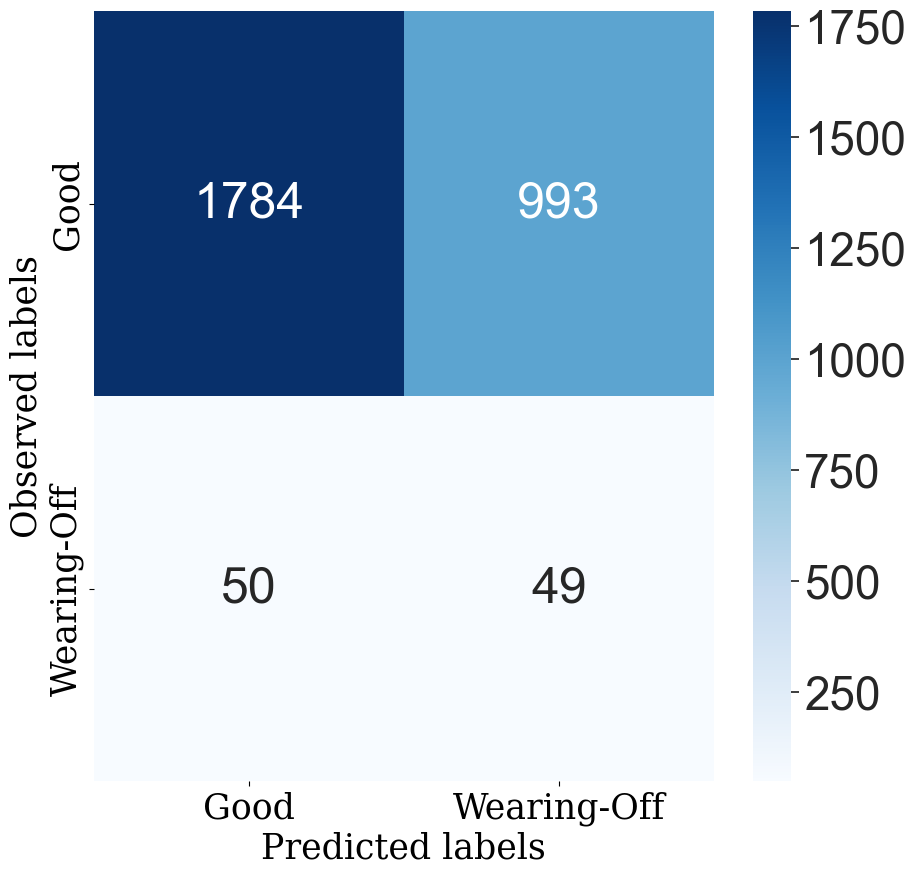

In [17]:
final_pipeline1 = Hyperpipe('5 - Final Pipeline CI GB',
                    outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                    inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                    use_test_set = True,
                    metrics = list(metrics.keys()),
                    best_config_metric='balanced_accuracy',
                    optimizer='sk_opt',
                    optimizer_params={'n_configurations': 30},
                    project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                    cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                    verbosity=1,
                    performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
final_pipeline1 += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

final_pipeline1 += PipelineElement('GradientBoostingClassifier', 
                            hyperparameters={
                                'loss': ['deviance', 'exponential'],
                                'learning_rate': FloatRange(0.001, 1, 'logspace')
                            }, random_state=4)

# Fit hyperpipe
final_pipeline1.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(final_pipeline1.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(final_pipeline1)

# # View CV splits for debugging
# for k,v in final_pipeline1.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(final_pipeline1, with_estimator_comparison=False)

# Show confusion matrix
plot_confusion_matrix_from_pipeline(final_pipeline1)


In [18]:
# Alternative 1: Built-in Feature Importances (Fastest)
print("Method 1: Built-in GradientBoosting Feature Importances")
print("-" * 55)
try:
    # Get the trained estimator
    gb_estimator = final_pipeline1.optimum_pipe.named_steps['GradientBoostingClassifier']
    
    if hasattr(gb_estimator, 'feature_importances_'):
        importances = gb_estimator.feature_importances_
        feature_names = np.array(columns[1:-1])
        
        # Sort by importance
        indices = np.argsort(importances)[::-1]
        
        for i, idx in enumerate(indices):
            print(f"{feature_names[idx]:<20} {importances[idx]:.4f}")
    else:
        print("Built-in feature importances not available")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")


Method 1: Built-in GradientBoosting Feature Importances
-------------------------------------------------------
time_from_last_drug_taken 0.8915
heart_rate           0.0620
light                0.0446
deep                 0.0019
total                0.0000
nonrem_percentage    0.0000
sleep_efficiency     0.0000
rem                  0.0000
nonrem_total         0.0000
awake                0.0000
stress_score         0.0000
steps                0.0000




In [19]:
# Alternative 2: Using sklearn's permutation_importance directly
print("Method 2: Sklearn Permutation Importance")
print("-" * 40)
try:
    from sklearn.inspection import permutation_importance
    
    # Get the fitted pipeline
    fitted_pipeline = final_pipeline1.optimum_pipe
    
    # Use a subset of data for faster computation (optional)
    # X_sample = X.sample(n=min(1000, len(X)), random_state=42)
    # y_sample = y.loc[X_sample.index]
    
    # Calculate permutation importance
    perm_importance = permutation_importance(
        fitted_pipeline, X, y, 
        n_repeats=10,  # Reduced for speed
        random_state=42,
        scoring='balanced_accuracy'
    )
    
    feature_names = np.array(columns[1:-1])
    
    # Sort by importance
    indices = np.argsort(perm_importance.importances_mean)[::-1]
    
    for i, idx in enumerate(indices):
        print(f"{feature_names[idx]:<20} {perm_importance.importances_mean[idx]:.4f} "
              f"±{perm_importance.importances_std[idx]:.4f}")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 2: Sklearn Permutation Importance
----------------------------------------
Error: 'PhotonPipeline' object has no attribute 'classes_'




In [20]:
# Alternative 3: SHAP Values (if you have shap installed)
print("Method 3: SHAP Feature Importance")
print("-" * 35)
try:
    import shap
    
    # Get the fitted pipeline
    fitted_pipeline = final_pipeline1.optimum_pipe
    
    # Use a sample for SHAP (it can be slow on large datasets)
    X_sample = X.sample(n=min(500, len(X)), random_state=42)
    
    # Create explainer
    explainer = shap.Explainer(fitted_pipeline, X_sample)
    shap_values = explainer(X_sample)
    
    # Get mean absolute SHAP values as feature importance
    feature_importance = np.abs(shap_values.values).mean(0)
    feature_names = np.array(columns[1:-1])
    
    # Sort by importance
    indices = np.argsort(feature_importance)[::-1]
    
    for i, idx in enumerate(indices):
        print(f"{feature_names[idx]:<20} {feature_importance[idx]:.4f}")
        
except ImportError:
    print("SHAP not installed. Install with: pip install shap")
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 3: SHAP Feature Importance
-----------------------------------
Error: The passed model is not callable and cannot be analyzed directly with the given masker! Model: PhotonPipeline(elements=[('ImbalancedDataTransformer',
                          PipelineElement(config=None, method_name='SMOTE',
                                          name='ImbalancedDataTransformer')),
                         ('GradientBoostingClassifier',
                          PipelineElement(ccp_alpha=0.0,
                                          criterion='friedman_mse', init=None,
                                          learning_rate=0.001140444703947033,
                                          loss='exponential', max_depth=3,
                                          max_features=None,
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_samples_leaf=1,
                   

In [21]:
# Alternative 4: Simple DataFrame approach for better visualization
print("Method 4: DataFrame Summary")
print("-" * 25)
try:
    import pandas as pd
    
    # Using the original hyperpipe method but organizing results better
    r = final_pipeline1.get_permutation_feature_importances(
        n_repeats=20,  # Reduced for speed
        random_state=0, 
        scoring='balanced_accuracy'
    )
    
    # Create DataFrame for better organization
    importance_df = pd.DataFrame({
        'Feature': np.array(columns[1:-1]),
        'Importance': r["mean"],
        'Std_Dev': r["std"],
        'Lower_Bound': r["mean"] - 2 * r["std"],
        'Upper_Bound': r["mean"] + 2 * r["std"]
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Display top 10
    print("Top 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False, float_format='%.4f'))
    
    # Show only statistically significant features
    significant_features = importance_df[importance_df['Lower_Bound'] > 0]
    
    if len(significant_features) > 0:
        print(f"\nStatistically Significant Features ({len(significant_features)}):")
        print(significant_features.to_string(index=False, float_format='%.4f'))
    else:
        print("\nNo statistically significant features found")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 4: DataFrame Summary
-------------------------

Computing permutation importances. This may take a while.
*****************************************************************************************************
Permutation Importances: Fitting model for outer fold 1
Permutation Importances: Calculating performances for outer fold 1
Error: 'PhotonPipeline' object has no attribute 'classes_'




In [22]:
# Alternative 5: Quick and Simple (Minimal Code)
print("Method 5: Quick and Simple")
print("-" * 25)
try:
    # Just get the built-in importances with minimal code
    estimator = final_pipeline1.optimum_pipe.named_steps['GradientBoostingClassifier']
    importances = estimator.feature_importances_
    features = np.array(columns[1:-1])
    
    # Create sorted list of (importance, feature) tuples
    sorted_features = sorted(zip(importances, features), reverse=True)
    
    print("Feature Importance Ranking:")
    for i, (importance, feature) in enumerate(sorted_features[:15], 1):
        print(f"{i:2d}. {feature:<20} {importance:.4f}")
        
except Exception as e:
    print(f"Error: {e}")

Method 5: Quick and Simple
-------------------------
Feature Importance Ranking:
 1. time_from_last_drug_taken 0.8622
 2. light                0.0558
 3. rem                  0.0447
 4. heart_rate           0.0255
 5. deep                 0.0054
 6. sleep_efficiency     0.0027
 7. stress_score         0.0021
 8. nonrem_percentage    0.0014
 9. awake                0.0003
10. total                0.0000
11. steps                0.0000
12. nonrem_total         0.0000
